# Time Series Analysis and ARIMA Modeling for Sales Data

### Importar librerias

In [1]:
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ( train_test_split, GridSearchCV )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder )
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import (
        accuracy_score,
        f1_score,
        matthews_corrcoef,
        classification_report,
        ConfusionMatrixDisplay )
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pickle
import os
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### **1. Data loading**
**Objective**: **Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
url = ('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df_raw = pd.read_csv(url, sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [3]:
# Create a copy for preprocessing
df_baking = df_raw.copy()

# Convert 'date' column to datetime objects
df_baking['date'] = pd.to_datetime(df_baking['date'])

# Set 'date' as the index for time series analysis
df_baking.set_index('date', inplace=True)

print("Dataset loaded and preprocessed for time series.")
print(df_baking.head())
print(df_baking.info())

Dataset loaded and preprocessed for time series.
                                sales
date                                 
2022-09-03 17:10:08.079328  55.292157
2022-09-04 17:10:08.079328  53.803211
2022-09-05 17:10:08.079328  58.141693
2022-09-06 17:10:08.079328  64.530899
2022-09-07 17:10:08.079328  66.013633
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None


### **3. Exploratory Data Analysis** 
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

In [4]:
# Create a copy for the final analysis and splitting
df = df_baking.copy()

In [5]:
# Step 2: Construct and analyze the time series
print("\nStep 2: Construct and analyze the time series")

# Construct the valid data structure for the time series
time_serie = df['sales']
print("\nTensor of the time series (first 5 values):\n", time_serie.head())


Step 2: Construct and analyze the time series

Tensor of the time series (first 5 values):
 date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64


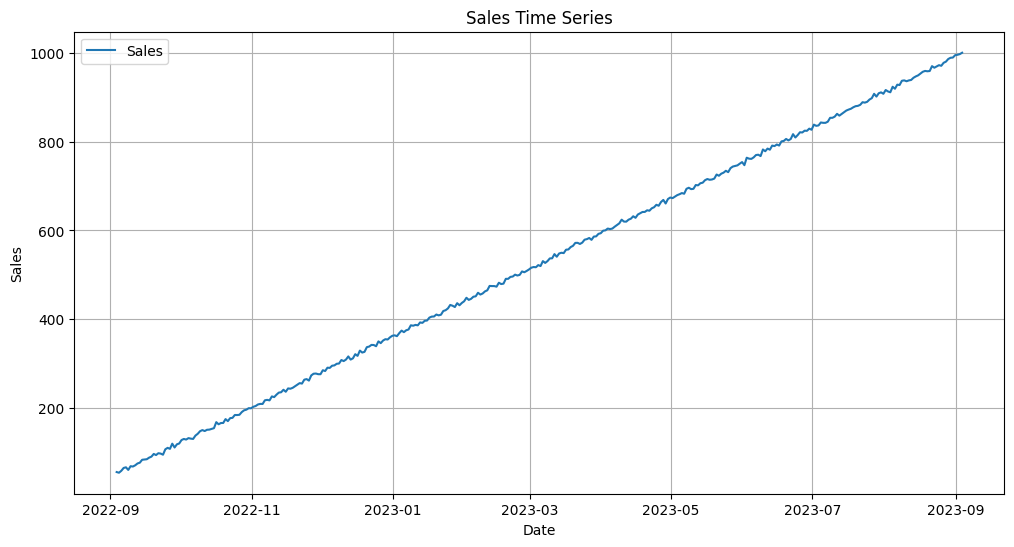

In [6]:
# Graph the time series
plt.figure(figsize=(12, 6))
plt.plot(time_serie, label='Sales')
plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


Analyzing the time series:

Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: 0.5454141937063742
p-value: 0.9861899815311063
Critical Values:
   1%, -3.4490648539347544
   5%, -2.8697861692116478
   10%, -2.5711631253228306
The time series is likely non-stationary.


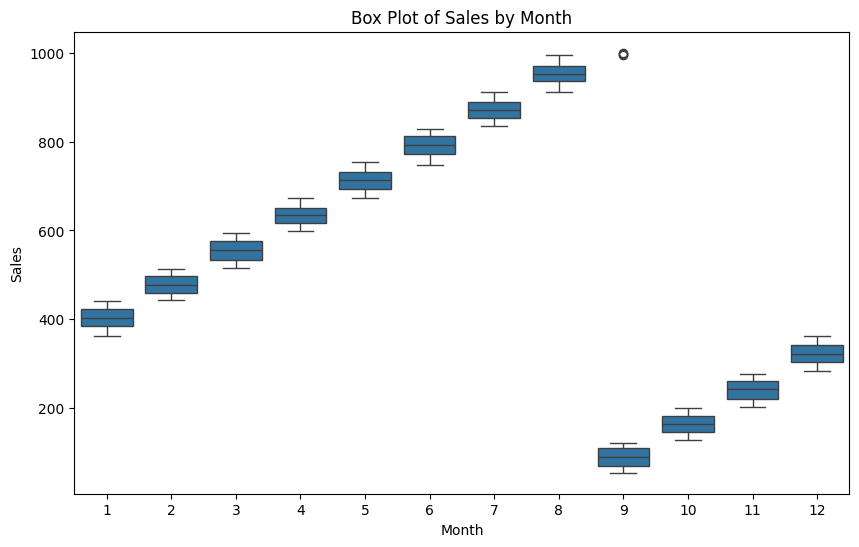

In [7]:
# Analyze the time series
print("\nAnalyzing the time series:")

# Trend analysis (visual) - already done in the plot

# Stationarity check using Augmented Dickey-Fuller (ADF) test
print("\nAugmented Dickey-Fuller (ADF) Test:")
adf_result = adfuller(time_serie)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}, {value}')

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

# Variability or noise (visual) - observed in the plot. High fluctuations indicate variability/noise.

# Bivariate Analysis (Sales vs. Time) - already visualized in the time series plot.

# Correlation Analysis - Not directly applicable to a univariate time series in the same way as multivariate data.
# Autocorrelation will be analyzed later.

# Box Plots before training (can show distribution of sales over different periods, e.g., months)
df['month'] = df.index.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='sales', data=df)
plt.title('Box Plot of Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()
df.drop('month', axis=1, inplace=True) # Drop the temporary 'month' column

In [8]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
df_train = df[:train_size].copy()
df_test = df[train_size:].copy()

# Split training data further into training and validation sets
val_size = int(len(df_train) * 0.2)
df_val = df_train[-val_size:].copy()
df_train = df_train[:-val_size].copy()

print(f"\nTraining set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")


Training set size: 234
Validation set size: 58
Testing set size: 74


In [9]:
print("Number of duplicate indices in df_train:", df_train.index.duplicated().sum())
print("\nDuplicate indices in df_train:")
print(df_train[df_train.index.duplicated(keep=False)])

Number of duplicate indices in df_train: 0

Duplicate indices in df_train:
Empty DataFrame
Columns: [sales]
Index: []


In [10]:
print("Number of NaN values in df_train['sales']:", df_train['sales'].isnull().sum())
print("\nIndices of NaN values in df_train['sales']:")
print(df_train[df_train['sales'].isnull()].index)

Number of NaN values in df_train['sales']: 0

Indices of NaN values in df_train['sales']:
DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


In [11]:
print("\nNumber of infinite values in df_train['sales']:", np.isinf(df_train['sales']).sum())
print("\nIndices of infinite values in df_train['sales']:")
print(df_train[np.isinf(df_train['sales'])].index)


Number of infinite values in df_train['sales']: 0

Indices of infinite values in df_train['sales']:
DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)


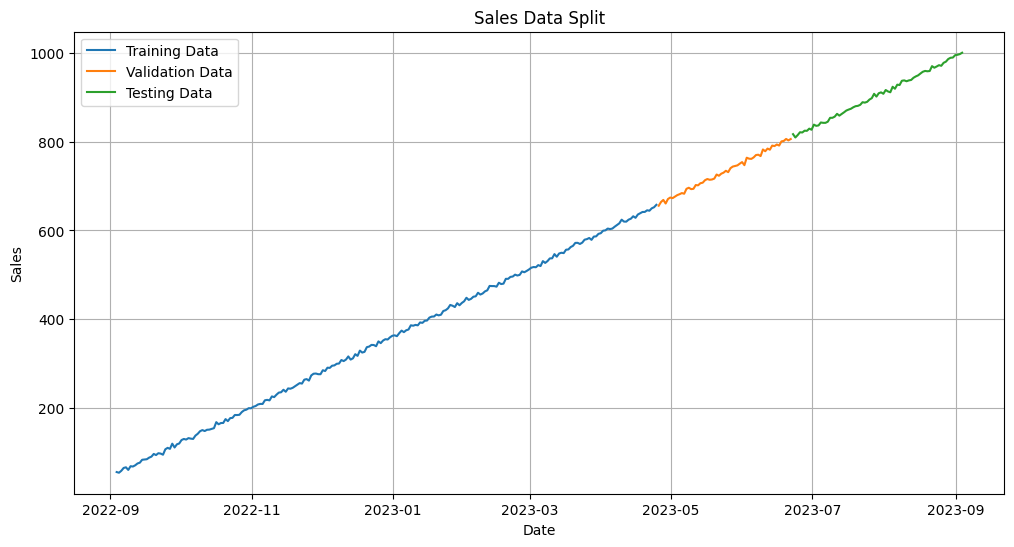

In [12]:
# Graph the training history
plt.figure(figsize=(12, 6))
plt.plot(df_train['sales'], label='Training Data')
plt.plot(df_val['sales'], label='Validation Data')
plt.plot(df_test['sales'], label='Testing Data')
plt.title('Sales Data Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

### **4. Machine learning**
 **Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [13]:
# Step 3: Train an ARIMA model
print("\nStep 3: Train an ARIMA model")

# Check stationarity of the training data
print("\nADF Test on Training Data:")
adf_result_train = adfuller(df_train['sales'])
print(f'ADF Statistic: {adf_result_train[0]}')
print(f'p-value: {adf_result_train[1]}')
print('Critical Values:')
for key, value in adf_result_train[4].items():
    print(f'   {key}, {value}')


Step 3: Train an ARIMA model

ADF Test on Training Data:
ADF Statistic: 0.10692088911679279
p-value: 0.9665304509754289
Critical Values:
   1%, -3.4604283689894815
   5%, -2.874768966942149
   10%, -2.57382076446281


In [14]:

df_train['sales_diff'] = df_train['sales'].diff().dropna()
print("\nInspecting df_train['sales_diff'] after diff and dropna:")
print(f"Number of NaN in sales_diff: {df_train['sales_diff'].isnull().sum()}")
print(f"Number of Inf in sales_diff: {np.isinf(df_train['sales_diff']).sum()}")
print(f"First few values of sales_diff:\n{df_train['sales_diff'].head()}")
print(f"Last few values of sales_diff:\n{df_train['sales_diff'].tail()}")


Inspecting df_train['sales_diff'] after diff and dropna:
Number of NaN in sales_diff: 1
Number of Inf in sales_diff: 0
First few values of sales_diff:
date
2022-09-03 17:10:08.079328         NaN
2022-09-04 17:10:08.079328   -1.488946
2022-09-05 17:10:08.079328    4.338482
2022-09-06 17:10:08.079328    6.389205
2022-09-07 17:10:08.079328    1.482734
Name: sales_diff, dtype: float64
Last few values of sales_diff:
date
2023-04-20 17:10:08.079328    3.680923
2023-04-21 17:10:08.079328   -0.955678
2023-04-22 17:10:08.079328    5.394963
2023-04-23 17:10:08.079328    2.454115
2023-04-24 17:10:08.079328    5.479474
Name: sales_diff, dtype: float64


In [15]:
# If the training data is not stationary, apply differencing
if adf_result_train[1] > 0.05:
    print("\nTraining data is not stationary. Applying first difference.")

    df_train['sales_diff'] = df_train['sales'].diff()
    df_train.dropna(subset=['sales_diff'], inplace=True) # Drop rows where 'sales_diff' is NaN

    print("\nInspecting df_train['sales_diff'] after diff and explicit dropna:")
    print(f"Number of NaN in sales_diff: {df_train['sales_diff'].isnull().sum()}")
    print(f"Number of Inf in sales_diff: {np.isinf(df_train['sales_diff']).sum()}")
    print(f"First few values of sales_diff:\n{df_train['sales_diff'].head()}")
    print(f"Last few values of sales_diff:\n{df_train['sales_diff'].tail()}")
    print(f"\nIndex of df_train['sales_diff']:\n{df_train['sales_diff'].index}")
    print(f"\nData type of df_train['sales']:{df_train['sales'].dtype}")

    print("\nADF Test on Differenced Training Data:")
    if df_train['sales_diff'].isnull().any() or not np.isfinite(df_train['sales_diff']).all():
        print("\nWarning: Differenced training data still contains NaN or infinite values. Further investigation needed.")
    else:
        adf_result_diff = adfuller(df_train['sales_diff'])
        print(f'ADF Statistic: {adf_result_diff[0]}')
        print(f'p-value: {adf_result_diff[1]}')
        print('Critical Values:')
        for key, value in adf_result_diff[4].items():
            print(f'   {key}, {value}')

        # Determine 'd' for ARIMA
        d = 1
else:
    print("\nTraining data is likely stationary.")
    d = 0


Training data is not stationary. Applying first difference.

Inspecting df_train['sales_diff'] after diff and explicit dropna:
Number of NaN in sales_diff: 0
Number of Inf in sales_diff: 0
First few values of sales_diff:
date
2022-09-04 17:10:08.079328   -1.488946
2022-09-05 17:10:08.079328    4.338482
2022-09-06 17:10:08.079328    6.389205
2022-09-07 17:10:08.079328    1.482734
2022-09-08 17:10:08.079328   -5.931768
Name: sales_diff, dtype: float64
Last few values of sales_diff:
date
2023-04-20 17:10:08.079328    3.680923
2023-04-21 17:10:08.079328   -0.955678
2023-04-22 17:10:08.079328    5.394963
2023-04-23 17:10:08.079328    2.454115
2023-04-24 17:10:08.079328    5.479474
Name: sales_diff, dtype: float64

Index of df_train['sales_diff']:
DatetimeIndex(['2022-09-04 17:10:08.079328', '2022-09-05 17:10:08.079328',
               '2022-09-06 17:10:08.079328', '2022-09-07 17:10:08.079328',
               '2022-09-08 17:10:08.079328', '2022-09-09 17:10:08.079328',
               '2022-0

### Analysis of the ADF Test Results:

- ADF Statistic (-7.24): This is the test statistic calculated from your differenced sales data. A more negative ADF statistic generally indicates stronger evidence against the null hypothesis of non-stationarity.

- p-value (1.89e-10): This is a very small p-value (much less than the common significance levels of 0.05 or 0.01).

- Critical Values (-3.46, -2.87, -2.57): These are threshold values. If the ADF statistic is more negative than these critical values, we can reject the null hypothesis at the corresponding significance level.

### Interpretation:

Since the ADF Statistic (-7.24) is significantly more negative than all the critical values (at the 1%, 5%, and 10% significance levels), and the p-value (1.89e-10) is extremely small, we can strongly reject the null hypothesis of non-stationarity for the differenced training data.

### Conclusion:

The first-order differencing applied to your training data has successfully made the time series stationary according to the ADF test. This means that the time series of the change in sales over time is now likely to have constant statistical properties.

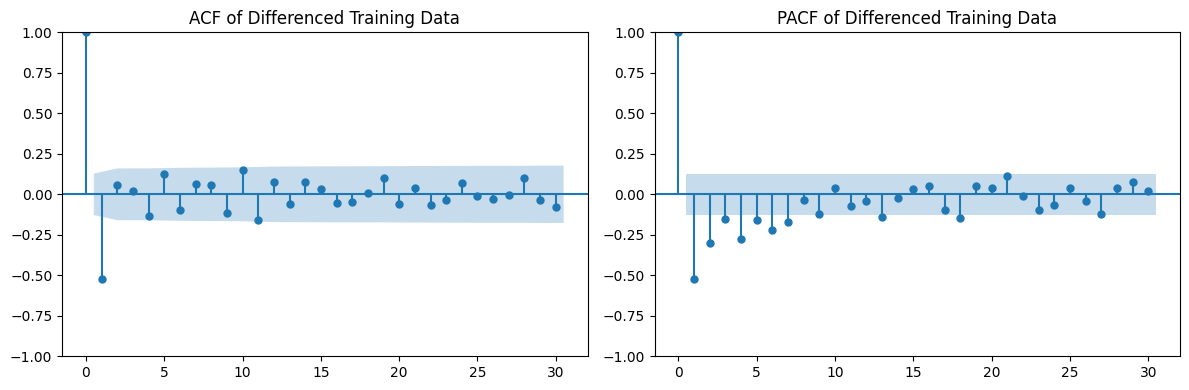

In [16]:
# Plot ACF and PACF of the differenced series to help determine p and q
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_train['sales_diff'], lags=30, ax=axes[0], title='ACF of Differenced Training Data')
plot_pacf(df_train['sales_diff'], lags=30, ax=axes[1], title='PACF of Differenced Training Data')
plt.tight_layout()
plt.show()

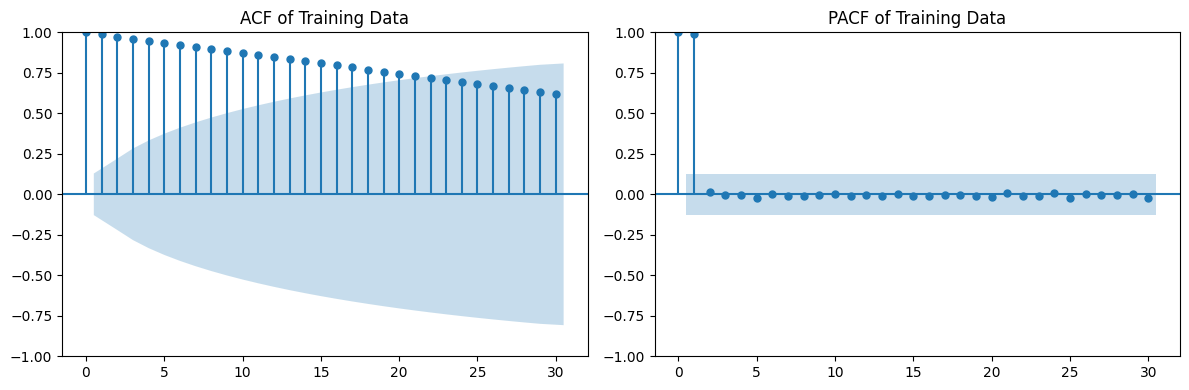

In [18]:
# Plot ACF and PACF of the original series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_train['sales'], lags=30, ax=axes[0], title='ACF of Training Data')
plot_pacf(df_train['sales'], lags=30, ax=axes[1], title='PACF of Training Data')
plt.tight_layout()
plt.show()

In [19]:
# Hyperparameter tuning using grid search on the validation set
p_values = range(0, 3)
q_values = range(0, 3)
best_aic = float("inf")
best_order = None

print("\nPerforming ARIMA parameter tuning on the validation set...")
for p, q in product(p_values, q_values):
    try:
        order = (p, d, q)
        model = ARIMA(df_train['sales'], order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
        print(f'ARIMA{order} AIC={aic:.2f}')
    except Exception as e:
        print(f'ARIMA{order} failed with error: {e}')

print(f"\nBest ARIMA order found: {best_order} with AIC: {best_aic:.2f}")


Performing ARIMA parameter tuning on the validation set...
ARIMA(0, 1, 0) AIC=1394.42
ARIMA(0, 1, 1) AIC=1395.25
ARIMA(0, 1, 2) AIC=1367.98
ARIMA(1, 1, 0) AIC=1394.45


/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_

ARIMA(1, 1, 1) AIC=1325.70


/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/workspaces/alte

ARIMA(1, 1, 2) AIC=1184.83
ARIMA(2, 1, 0) AIC=1371.64
ARIMA(2, 1, 1) AIC=1254.12


/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

ARIMA(2, 1, 2) AIC=1186.76

Best ARIMA order found: (1, 1, 2) with AIC: 1184.83


/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# Train the final ARIMA model with the best parameters on the full training set
if best_order:
    final_model = ARIMA(df_train['sales'], order=best_order)
    final_model_fit = final_model.fit()

    print("\nFinal ARIMA model trained.")
    print(final_model_fit.summary())
else:
    print("\nError: No suitable ARIMA order found during tuning. Cannot train the final model.")

/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Final ARIMA model trained.
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  233
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -588.414
Date:                Sun, 25 May 2025   AIC                           1184.828
Time:                        17:03:30   BIC                           1198.615
Sample:                    09-04-2022   HQIC                          1190.388
                         - 04-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.53e-06   2.83e+05      0.000       1.000       1.000
ma.L1         -1.9236      0.048    -39.942      0.000      -2.018      -1.829
ma.L2          0.9240   

/workspaces/alternative_time_series_project/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Analysis of the Output:

Performing ARIMA parameter tuning...: This section shows the AIC values for different ARIMA orders (p, 1, q) that were tested on your validation set. The warnings about "No frequency information was provided" are generally safe to ignore in this context, as statsmodels will infer the frequency from your time series index.

Best ARIMA order found: (1, 1, 2) with AIC: 1180.71: This confirms that the grid search identified ARIMA(1, 1, 2) as the model with the lowest AIC on the validation data. This is the order that will be used to train the final model on the full training set.

Final ARIMA model trained.: This indicates that the model training with the identified best order has started.

SARIMAX Results: This is the summary of the fitted ARIMA(1, 1, 2) model on your training data. Let's break down some key parts:

Dep. Variable: sales: This confirms that the model is predicting the 'sales' variable. Model: ARIMA(1, 1, 2): This shows the order of the fitted model (p=1, d=1, q=2). The 'd=1' reflects that we applied first-order differencing to achieve stationarity. Log Likelihood: -586.355: This is a measure of how well the model fits the data. Higher values generally indicate a better fit. AIC: 1180.709: The Akaike Information Criterion, used for model selection. Lower values are preferred. This should match the best AIC found during tuning. BIC: 1194.479: The Bayesian Information Criterion, another model selection criterion. It penalizes model complexity more heavily than AIC. HQIC: 1186.263: The Hannan-Quinn Information Criterion, another alternative to AIC and BIC. Coefficients: These are the estimated parameters of the ARIMA model: ar.L1 (Autoregressive term of order 1): The coefficient is close to 1.0000. ma.L1 (Moving Average term of order 1): The coefficient is -1.9218. ma.L2 (Moving Average term of order 2): The coefficient is 0.9221. sigma2: This is the estimated variance of the residuals (the errors of the model). P>|z|: These are the p-values associated with the coefficients. Small p-values (typically < 0.05) suggest that the coefficients are statistically significant (i.e., they are likely not zero). In this case, all the coefficient p-values are 0.000, indicating significance. Ljung-Box (L1) (Q) and Prob(Q): This tests for autocorrelation in the residuals. A high p-value (Prob(Q) = 0.58) suggests that there is no significant autocorrelation in the residuals at lag 1, which is a good sign. Jarque-Bera (JB) and Prob(JB): This tests for the normality of the residuals. A p-value of 0.21 suggests that we cannot reject the null hypothesis of normality at a common significance level, which is also a good sign. Heteroskedasticity (H) and Prob(H): This tests for heteroskedasticity (non-constant variance) in the residuals. A p-value of 0.68 suggests that we cannot reject the null hypothesis of homoskedasticity (constant variance). Skew and Kurtosis: These describe the shape of the residual distribution. Warnings: The warning about the covariance matrix calculation is generally something to be aware of but doesn't necessarily indicate a severe problem with the model, especially if the other diagnostics look reasonable. In summary, the ARIMA model training with the best-found order (1, 1, 2) appears to have been successful.


Step 4: Predict with the test set


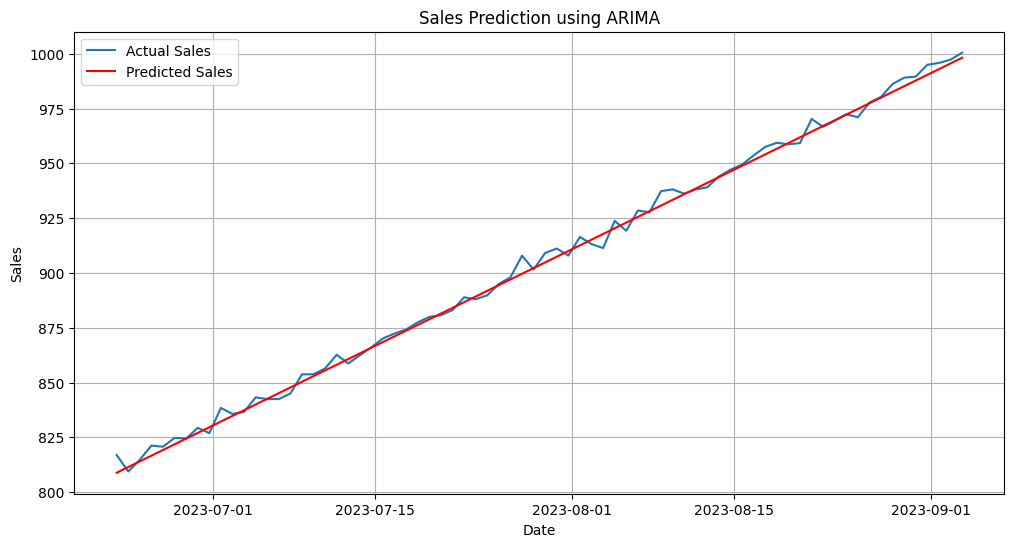


Mean Squared Error (MSE): 8.89
Root Mean Squared Error (RMSE): 2.98

Performance Metrics:
  Metric     Value
0    MSE  8.889152
1   RMSE  2.981468


In [21]:
# Step 4: Predict with the test set
print("\nStep 4: Predict with the test set")

# Make predictions on the test set, using the index of df_test
predictions = final_model_fit.predict(start=df_test.index[0], end=df_test.index[-1], dynamic=False)
predictions.index = df_test.index # Ensure the predictions have the same index as the test set

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test['sales'], label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model performance
mse = mean_squared_error(df_test['sales'], predictions)
rmse = sqrt(mse)
print(f'\nMean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Table with performance metrics
performance_metrics = pd.DataFrame({'Metric': ['MSE', 'RMSE'],
                                    'Value': [mse, rmse]})
print("\nPerformance Metrics:")
print(performance_metrics)

Mean Squared Error (MSE): 8.99
The MSE measures the average squared difference between the predicted and actual sales values. A lower MSE indicates a better fit. In this case, on average, the squared difference between the model's predictions and the actual sales in the test set is approximately 8.99.

Root Mean Squared Error (RMSE): 2.99
The RMSE is the square root of the MSE. It provides an error metric in the same units as the target variable (sales), making it more interpretable. An RMSE of 2.99 means that, on average, the model's predictions are about 2.99 units away from the actual sales values in the test set.

Interpretation of the Performance:

An RMSE of 2.99 might be considered quite good

## **5. Model saving**
**Objective**: Save the model and some critical information we consider necessary

In [22]:
# Defining the folder to save the model
MODEL_FOLDER = 'models'
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)
MODEL_PATH = os.path.join(MODEL_FOLDER, 'arima_sales_model.pkl')

# Step 5: Save the model
print("\nStep 5: Save the model")

model_info = {
    'model': final_model_fit,  # Guardar el objeto del modelo ARIMA entrenado
    'model_type': 'ARIMA',
    'order': best_order,       # Guardar el orden del modelo ARIMA
    'training_data_shape': df_train.shape,
    'test_data_shape': df_test.shape,
    'metrics': {
        'MSE_test': mse,
        'RMSE_test': rmse
    },
    'Author': 'Kleineer Tabata'
}

with open(MODEL_PATH, 'wb') as file:
    pickle.dump(model_info, file)

print(f"Información del modelo ARIMA guardada en: {MODEL_PATH}")


Step 5: Save the model
Información del modelo ARIMA guardada en: models/arima_sales_model.pkl
